# RAU_Calc Project



### Table of Contents

- [General Documentation (I)](#gendoc)

- [Importing & Navigating (II)](#importnav)

- [Pulling Files (III)](#pullfiles)
    
- [Concentration Calculations (IV)](#concalc)
    
- [Nitrate Calculations (V)](#nitcalc)

- [Ureide Calculations (VI)](#urecalc)

- [Merging Dataframes (VII)](#mergedata)

- [RAU Calculations (VIII)](#raucalc)

- [Saving Final Dataframe (IX)](#finaldata)


<a name="gendoc"></a>

---------
### I) General Documentation

#### Purpose: 
> Pulling data from ureide and nitrate spectrophotometry sheets and calculating Relative Abundance of Ureides (RAU%) in a given sample based on concentrations of ureides and nitrates for that sample. Concentrations are calculated by extrapolating values based on curve and blank information unique to each data sheet.

#### Inputs:
> Cloned repository on user's computer - code will automatically navigate to correct folder.

> Correctly formatted datasheets in the "Datasets" directory. <br>
_If user does not want sheets to be re-run in future , save in a new folder in "Datasets" directory._

> Number of files is not important, as long as each sample has a unique ID.

#### Outputs:
> .csv file with four columns - Sample ID, nitrate concentration (micromoles/gram), ureide concentration (micromoles/gram), and final RAU calculations.

> Data is sorted and matched based on the Sample_ID information.

#### Author: Rachel Veenstra
#### Updated: 05-07-2019

<a name="importnav"></a>

---------
### II) Importing and Navigating

- Required modules: **os, pandas, numpy, glob, and scipy.stats.linregress**
- Navigation to correct folder in cloned repository ('Datasets') is automated
- Directory is displayed for user to view

In [2]:
# Importing necessary modules

import os
import pandas as pd
import numpy as np
import glob
from scipy.stats import linregress



# Setting working directory and navigating

loc = glob.os.getcwd()

if loc.split("\\")[-1] != "Datasets":  # Conditional to avoid overwriting current directory
    loc = loc + '/Datasets/'

glob.os.chdir(loc)

print(glob.os.getcwd())  # Displaying directory for user to view


C:\Users\Rachel Veenstra\Desktop\Coding\AGRON935-Semester-Project\Datasets


<a name="pullfiles"></a>

---------
### III) Pulling all .csv Files from "Datasets" Folder

- Datasets to be run by code should be saved as .csv files in "Datasets" folder
- Code will grab ALL .csv files in this folder
- Number of files found is displayed for user to view

In [3]:
# Mass-importing all files from specified datasets folder

all_data = glob.glob(loc + "/*.csv")

print(len(all_data)) # Displaying number of datasheets read by code for user
print(all_data[1]) # Displaying sample of code-read datasheet

4
C:\Users\Rachel Veenstra\Desktop\Coding\AGRON935-Semester-Project\Datasets\RV2_URE_Example.csv


<a name="concalc"></a>

------
### IV) Spectrophotometry Concentration Calculations

- Each sheet has three components: blanks, curves, and samples
- Blanks serve as the "zero" for a sheet
- Curves provide references for extrapolating concentration values of samples
- Samples are of an unknown concentration

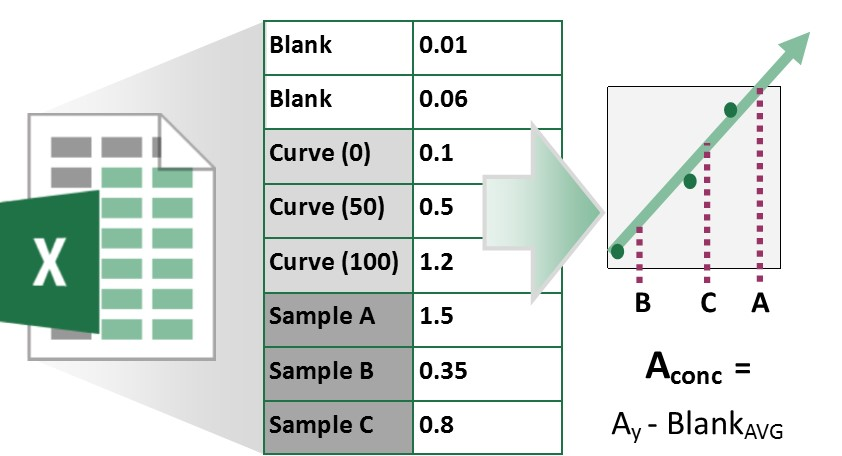

In [4]:
from IPython.display import Image
Image(filename='Calc_Flow_Chart.jpg')

<a name="nitcalc"></a>

---------
### V) Nitrate Concentrations

- Utilizes lists for storing values
- Groups dataframe based on 'Sample_ID' Column
>Calculates mean for each group
- Identifies curves, blanks, and samples based on 'Type' Column:
> **B:** Blank <br>
**C:** Curve <br>
**O:** Original Sample <br>
**D:** Duplicate Sample
- Calculates blank average (B)
- Calculates slope and intercept of line fit to curve points (C)
- Using following equation, calculates concentration of each sample based on absorbance:


$$\frac{\Bigl( \Bigl(\frac {Sample_O + Sample_ D}{2} - Blank_{AVG}\Bigr) * slope\Bigr) + intercept}{\frac{Weight(g)}{7.5} * 1000}$$ 


- Appends nitrate Sample_ID information and calculated concentration to respective lists

In [5]:
# Creating lists to be appended with values from future dataframes

n_final_id = []
n_final_conc = []


# Looping through all files in dataset folder

for i in all_data:
    
    
    
    # Defining analysis type based on file name
    
    analysis = i.split('_')[-2]
    
    
    
    # Running only Nitrates files
    
    if analysis == 'NIT':
        
        
        # Identifying file
    
        print(i)
        
        
        # Reading data with pandas
        
        NDF = pd.read_csv(i)
        
        print(' ')
        print("Sample of original nitrate dataframe:")
        print(NDF[10:22]) # Displaying sample of original code-read dataframe
        
        
        
        # Copying only ID and absorbance to new dataframe for grouping functions
        
        nit_df = NDF[['Sample_ID', 'Absorbance']]
        
        
        # Each sample has duplicate readings, so data must be grouped by sample ID

        nit_g = nit_df.groupby('Sample_ID')
        
        print(' ')
        print("Properties of grouped dataframe:")
        print(nit_g.count()[0:10])
        
        
        # Creating a dataframe with the mean of each "sample group" and 
        # merging with copied dataframe based on ID ... this creates two
        # columns with absorbance data - one with the original reading, and
        # the other with the overall mean from that sample.

        nit_final=nit_df.merge(nit_g.mean(),on='Sample_ID')
        
        
        # Renaming columns for easy manipulation

        nit_final.rename(columns = {'Absorbance_x':'Each', 'Absorbance_y':'Mean'}, inplace=True)

        
        # Pulling other necessary calculation data from original dataframe
        
        nit_final['Type'] = NDF['Type']
        nit_final['Sample_Wt(g)'] = NDF['Sample_Wt(g)']
        
        
        print(' ')
        print("Manipulated Dataframe")
        print(nit_final[10:22])
        
        # Creating lists to append with curve and blank absorbance data

        c=[]
        m=[]
        blanks = []

        
        # Looping through rows in dataframe
        
        for i, row in nit_final.iterrows():
            
            
            # Pulling out only values tied to a curve reading

            if row['Type'] == 'C':
                
                
                # Appending known concentration and mean absorbance lists

                c.append(float(row['Sample_ID']))
                m.append(float(row['Mean']))
                
            
            # Pulling out only values tied to a blank reading
            
            elif row['Type'] == 'B':
                
                
                # Appending list of blank absorbance values

                blanks.append(float(row['Each']))
                
        
        # Taking the mean of blank values for use as base in final calculations
        
        blank_val = np.mean(blanks)
        
        print(' ')
        print("The value of the set blank is " + str(blank_val)) # Displaying blank value for set
        
        
        # Calculating properties of the calibration curve created by curve points
        # Saving each value as a unique variable
        
        slope, intercept, r_value, p_value, std_err = linregress(m, c)

        print("The slope of the calibration curve for this set is " + str(slope))
        print("The intercept of the calibration curve for this set is " + str(intercept))    
        
        
        # Looping through rows in dataframe
        
        for i, row in nit_final.iterrows():
            
            
            # Pulling out only values tied to an original sample reading
            # because we are using means for each sample, both the original
            # and duplicate Sample ID do not need to be on the final list
            
            if row['Type'] == 'O':
                
                
                # Appending the nitrates master list with both the calculated concentration
                # and the corresponding sample ID information

                n_final_conc.append(((row['Mean'] - blank_val)*slope + intercept)/((row['Sample_Wt(g)']*1000)/7.5))
                n_final_id.append(row['Sample_ID'])
                
    print(" ")

C:\Users\Rachel Veenstra\Desktop\Coding\AGRON935-Semester-Project\Datasets\RV2_NIT_Example.csv
 
Sample of original nitrate dataframe:
   Type  Sample_Wt(g) Sample_ID  Absorbance
10    C           NaN      3000       0.338
11    C           NaN      3000       0.337
12    C           NaN      3000       0.335
13    C           NaN      4500       0.479
14    C           NaN      4500       0.503
15    C           NaN      4500       0.499
16    O           0.3    RV2_01       0.061
17    D           0.3    RV2_01       0.061
18    O           0.3    RV2_02       0.143
19    D           0.3    RV2_02       0.140
20    O           0.3    RV2_03       0.201
21    D           0.3    RV2_03       0.198
 
Properties of grouped dataframe:
           Absorbance
Sample_ID            
0                   3
1500                3
1_1                 1
1_2                 1
2_1                 1
2_2                 1
3000                3
4500                3
RV2_01              2
RV2_02          

<a name="urecalc"></a>

---------
### VI) Ureide Concentrations

- Utilizes lists for storing values
- Groups dataframe based on 'Sample_ID' Column
>Calculates mean for each group
- Identifies curves, blanks, and samples based on 'Type' Column:
> **B:** Blank <br>
**C:** Curve <br>
**O:** Original Sample <br>
**D:** Duplicate Sample
- Calculates blank average (B)
- Calculates slope and intercept of line fit to curve points (C)
- Using following equation, calculates concentration of each sample based on absorbance:

$$\left(\frac{\left( \left(\frac {Sample_O + Sample_ D}{2} - Blank_{AVG}\right) * slope\right) + intercept}{\frac{Weight(g)}{7.5} * 1000}\right) * 4$$

- Appends nitrate Sample_ID information and calculated concentration

In [6]:
# Creating lists to be appended with values from future dataframes

u_final_id = []
u_final_conc = []



# Looping through all files in dataset folder

for i in all_data:
    
    
    # Defining analysis type based on file name
    
    analysis = i.split('_')[-2]    
    
    
    # Running only Ureides files
    
    if analysis == 'URE':
        
        
        # Identifying file
    
        print(i)
        
        
        # Reading data with pandas
        
        UDF = pd.read_csv(i)
        
        print(" ")
        print("Sample of original ureide dataframe:")
        print(UDF[10:22]) # Displaying sample of original code-read dataframe
        
        
        
        # Copying only ID and absorbance to new dataframe for grouping functions
        
        ure_df = UDF[['Sample_ID', 'Absorbance']]

        
        # Each sample has duplicate readings, so data must be grouped by sample ID
        
        ure_g = ure_df.groupby('Sample_ID')
       
        print(" ")
        print("Properties of grouped dataframe:")
        print(ure_g.count()[0:10])
        
        
        # Creating a dataframe with the mean of each "sample group" and 
        # merging with copied dataframe based on ID ... this creates two
        # columns with absorbance data - one with the original reading, and
        # the other with the overall mean from that sample.

        ure_final=ure_df.merge(ure_g.mean(),on='Sample_ID')
        
        
        # Renaming columns for easy manipulation

        ure_final.rename(columns = {'Absorbance_x':'Each', 'Absorbance_y':'Mean'}, inplace=True)

        
        # Pulling other necessary calculation data from original dataframe
        
        ure_final['Type'] = UDF['Type']
        ure_final['Sample_Wt(g)'] = UDF['Sample_Wt(g)']
        
        print(" ")
        print("Manipulated Dataframe:")
        print(ure_final[10:22])
        
        # Creating lists to append with curve and blank absorbance data

        c=[]
        m=[]
        blanks = []
        
        
        # Looping through rows in dataframe

        for i, row in ure_final.iterrows():
            
            
            # Pulling out only values tied to a curve reading

            if row['Type'] == 'C':
                
                
                # Appending known concentration and mean absorbance lists

                c.append(float(row['Sample_ID']))
                m.append(float(row['Mean']))


            # Pulling out only values tied to a blank reading    

            elif row['Type'] == 'B':
                
                
                # Appending list of blank absorbance values

                blanks.append(float(row['Each']))
                
                        
        # Taking the mean of blank values for use as base in final calculations        
                
        blank_val = np.mean(blanks)
       
        print(" ")
        print("The value of the set blank is " + str(blank_val)) # Displaying blank value for set
        
           
        # Calculating properties of the calibration curve created by curve points
        # Saving each value as a unique variable    
                
        slope, intercept, r_value, p_value, std_err = linregress(m, c)

        print("The slope of the calibration curve for this set is " + str(slope))
        print("The intercept of the calibration curve for this set is " + str(intercept))    
        
        
        # Looping through rows in dataframe
        
        for i, row in ure_final.iterrows():
            
            
            # Pulling out only values tied to an original sample reading
            # because we are using means for each sample, both the original
            # and duplicate Sample ID do not need to be on the final list
            
            if row['Type'] == 'O':

                
                # Appending the nitrates master list with both the calculated concentration
                # and the corresponding sample ID information
                
                u_final_conc.append(((row['Mean'] - blank_val)*slope + intercept)/((row['Sample_Wt(g)']*1000)/7.5)*4)
                u_final_id.append(row['Sample_ID'])
                
    print(" ")

 
C:\Users\Rachel Veenstra\Desktop\Coding\AGRON935-Semester-Project\Datasets\RV2_URE_Example.csv
 
Sample of original ureide dataframe:
   Type  Sample_Wt(g)    Sample_ID  Absorbance
10    C           NaN  1099.165191       0.668
11    C           NaN  1099.165191       0.672
12    C           NaN  1099.165191       0.666
13    C           NaN  4396.660764       2.576
14    C           NaN  4396.660764       2.567
15    C           NaN  4396.660764       2.643
16    O           0.3       RV2_01       0.267
17    D           0.3       RV2_01       0.265
18    O           0.3       RV2_02       0.352
19    D           0.3       RV2_02       0.376
20    O           0.3       RV2_03       0.636
21    D           0.3       RV2_03       0.620
 
Properties of grouped dataframe:
             Absorbance
Sample_ID              
0                     3
1099.165191           3
1_1                   1
1_2                   1
2_1                   1
2_2                   1
4396.660764           3
54

<a name="mergedata"></a>

---------
### VII) Creating Single Dataframe with Ureide and Nitrate Information

- Lists used to create dataframes
- Dataframes merged based on Sample_ID column

In [7]:
# Creating dataframes with empty columns to fill with data from lists created above

columns = ['Sample_ID', 'Concentration']

nitrates = pd.DataFrame(columns = columns)  

ureides = pd.DataFrame(columns = columns)



# Inserting data from lists into columns of the two dataframes

nitrates['Sample_ID'] = n_final_id
nitrates['Concentration'] = n_final_conc

ureides['Sample_ID'] = u_final_id
ureides['Concentration'] = u_final_conc



# Merging the two dataframes based on the information in their 'Sample_ID' columns

merged_df = pd.merge(nitrates, ureides, how='left', on='Sample_ID')



# Renaming columns to keep N and U straight

merged_df.rename(columns = {'Concentration_x':'Concentration_N', 'Concentration_y':'Concentration_U'}, inplace=True)


print("Nitrates Dataframe Sample")
print(nitrates.head()) # Displaying sample of nitrates dataframe

print(' ')
print("Ureides Dataframe Sample")
print(ureides.head()) # Displaying sample of ureides dataframe

print(' ')
print("Merged Dataframe Sample")
print(merged_df.head()) # Displaying sample of merged ureides/nitrates dataframe

Nitrates Dataframe Sample
  Sample_ID  Concentration
0    RV2_01      11.294133
1    RV2_02      29.766004
2    RV2_03      43.074929
3    RV2_04      47.664213
4    RV2_05       8.196366
 
Ureides Dataframe Sample
  Sample_ID  Concentration
0    RV2_01      40.216039
1    RV2_02      56.922103
2    RV2_03     101.926195
3    RV2_04      66.212720
4    RV2_05      19.162988
 
Merged Dataframe Sample
  Sample_ID  Concentration_N  Concentration_U
0    RV2_01        11.294133        40.216039
1    RV2_02        29.766004        56.922103
2    RV2_03        43.074929       101.926195
3    RV2_04        47.664213        66.212720
4    RV2_05         8.196366        19.162988


<a name="raucalc"></a>

---------
### VIII) Calculating RAU% with Nitrate & Ureide Concentrations

- RAU (Relative Abundance of Ureides) is calculated based on the following equation:
<br>

$$\left(\frac{Ureide_{conc}}{Ureide_{conc} + Nitrate_{conc}}\right) * 100 $$

- Added as new column of merged dataframe

In [8]:
# Creating an empty list to append with final RAU calculations

RAU  =[]



# Looping through rows in merged dataframe

for i, row in merged_df.iterrows():
    
    
    
    # Appending list with values calculated ureide portion of total nitrogen
    
    RAU.append((row['Concentration_U'] / (row['Concentration_N'] + row['Concentration_U']))*100)
    
    
    
# Inserting data from list into new column of merged data frame
    
merged_df['RAU'] = RAU

print('Merged Dataframe with Calculated RAU Values')
print(merged_df.head()) # Displaying sample of merged ureides/nitrates dataframe with calculated RAU  

Merged Dataframe with Calculated RAU Values
  Sample_ID  Concentration_N  Concentration_U        RAU
0    RV2_01        11.294133        40.216039  78.073975
1    RV2_02        29.766004        56.922103  65.663106
2    RV2_03        43.074929       101.926195  70.293383
3    RV2_04        47.664213        66.212720  58.144102
4    RV2_05         8.196366        19.162988  70.041815


<a name="finaldata"></a>

---------
### IX) Saving Final Dataframe

- Final dataframe saved as .csv file
- Can be found in 'RAU_Results' folder of cloned repository

In [9]:
# Assigning a location for saving the output file and navigating

directory = glob.os.getcwd().split('\\')[0:-1]
save_loc = ('\\').join(directory) + '\\RAU_Results'

glob.os.chdir(save_loc)



# Saving the dataframe as a .csv file in the specified saving location, ignoring index to preserve simple look

merged_df.to_csv('Final_RAU_Results.csv', index=False)



##### THE COMPLETED FILE WITH FINAL RAU CALCULATIONS CAN NOW BE FOUND IN THE 'RAU_Results' FOLDER!! #####